# Предсказание пола клиента по его транзакциям

In [52]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import joblib
import os

from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings
filterwarnings('ignore')


## Загрузка данных

In [53]:
PATH_DATA = '../data'
MODEL_PATH = "model.pkl"

In [54]:
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [55]:
transactions_train

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender
client_id,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0
...,...,...,...,...,...,...,...,...
fffedf876a0ea3d39e54b706165a4826,28 12:51:47,6011,2010,-10846.43,NaN,Saint Petersburg,3421,1
fffedf876a0ea3d39e54b706165a4826,55 07:37:08,6011,2010,-2170.15,NaN,Saint Petersburg,3421,1
fffedf876a0ea3d39e54b706165a4826,55 07:40:10,4814,1030,-71.41,NaN,Saint Petersburg,3421,1


## Анализ данных

#### transactions.csv

Этот файл содержит информацию о всех транзакциях пользователей без указания принадлежности к классу.

In [18]:
print(transactions.info())
print('\n')
print(transactions.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 3563529 entries, d1bbbc9a0e0410d3cf12a3d2f44f3450 to 8d69e4ecae4b509d528b9a0168f749d0
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   trans_time  object 
 1   mcc_code    int64  
 2   trans_type  int64  
 3   amount      float64
 4   term_id     object 
 5   trans_city  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 222.6+ MB
None


trans_time          0
mcc_code            0
trans_type          0
amount              0
term_id       1443778
trans_city          0
dtype: int64


В столбце <code>term_id</code> присутствует большое количество пропущенных значений. Использовать его в обучении модели бессмысленно.

#### tr_mcc_codes.csv

В файле присутствуют описания всех MCC кодов.

In [40]:
tr_mcc_codes.head()

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело


#### tr_types.csv

Файл содержит описание всех типов транзакций.

In [41]:
tr_types.head()

,trans_description
trans_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...


<code>gender_train</code> - пользователи, принадлежащие к тренировочной выборке

<code>gender_test</code> - пользователи, принадлежащие к тестовой выборке

<Axes: >

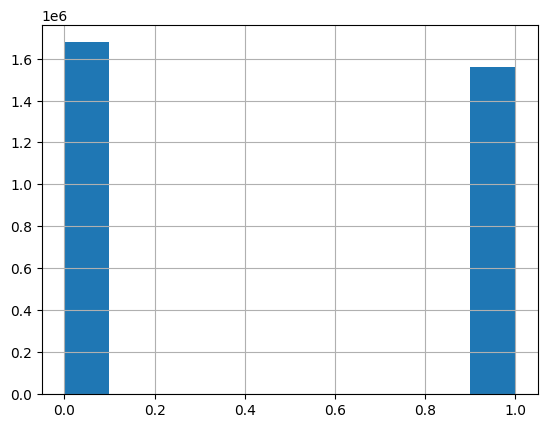

In [42]:
# Соотношение классов
transactions_train.gender.hist()

Этот датасет достаточно сбалансирован по классам.

Text(0, 0.5, 'Количество')

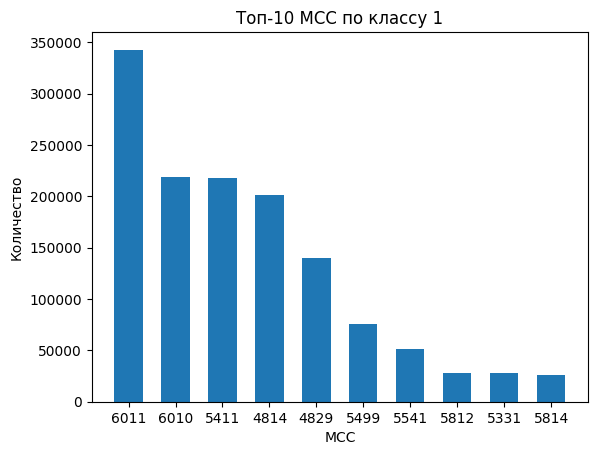

In [43]:
x_mcc_1 = transactions_train[transactions_train.gender == 1].mcc_code.value_counts().head(10).index.astype(str)
y_mcc_1 = transactions_train[transactions_train.gender == 1].mcc_code.value_counts().head(10).values

plt.bar(x_mcc_1, y_mcc_1, width=0.6)
plt.title('Топ-10 MCC по классу 1')
plt.xlabel('MCC')
plt.ylabel('Количество')

* Самый используемый mcc_code - это Финансовые институты — снятие наличности автоматически (то есть чаще всего люди 1 класса снимали наличные в банокамтах)
* 6010 - на втором месте. Снятие наличностей вручную с использованием карты (банки,кассы)
* 5411 - бакалейные лавки и супермаркеты
* 4814 Звонки с использованием телефонов, считывающих магнитную ленту



##### MCC_code класса 1

In [44]:
print('6011:',tr_mcc_codes.loc[6011, 'mcc_description'])
print('6010:',tr_mcc_codes.loc[6010, 'mcc_description'])
print('5411:',tr_mcc_codes.loc[5411, 'mcc_description'])
print('4814:',tr_mcc_codes.loc[4814, 'mcc_description'])
print('4829:',tr_mcc_codes.loc[4829, 'mcc_description'])
print('5499:',tr_mcc_codes.loc[5499, 'mcc_description'])
print('5541:',tr_mcc_codes.loc[5411, 'mcc_description'])
print('5331:',tr_mcc_codes.loc[5331, 'mcc_description'])
print('6011:',tr_mcc_codes.loc[6010, 'mcc_description'])
print('5814:',tr_mcc_codes.loc[5814, 'mcc_description'])


6011: Финансовые институты — снятие наличности автоматически
6010: Финансовые институты — снятие наличности вручную
5411: Бакалейные магазины, супермаркеты
4814: Звонки с использованием телефонов, считывающих магнитную ленту
4829: Денежные переводы
5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов
5541: Бакалейные магазины, супермаркеты
5331: Универсальные магазины
6011: Финансовые институты — снятие наличности вручную
5814: Рестораны, закусочные


Text(0, 0.5, 'Количество')

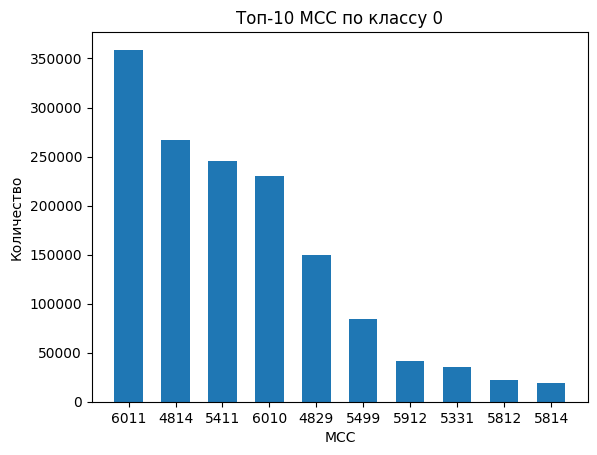

In [45]:
x_mcc_0 = transactions_train[transactions_train.gender == 0].mcc_code.value_counts().head(10).index.astype(str)
y_mcc_0 = transactions_train[transactions_train.gender == 0].mcc_code.value_counts().head(10).values

plt.bar(x_mcc_0, y_mcc_0, width=0.6)
plt.title('Топ-10 MCC по классу 0')
plt.xlabel('MCC')
plt.ylabel('Количество')

##### MCC_code класса 0

In [46]:
print('6011:',tr_mcc_codes.loc[6011, 'mcc_description'])
print('4814:',tr_mcc_codes.loc[4814, 'mcc_description'])
print('5411:',tr_mcc_codes.loc[5411, 'mcc_description'])
print('6010:',tr_mcc_codes.loc[6010, 'mcc_description'])
print('4829:',tr_mcc_codes.loc[4829, 'mcc_description'])
print('5499:',tr_mcc_codes.loc[5499, 'mcc_description'])
print('5912:',tr_mcc_codes.loc[5912, 'mcc_description'])
print('5331:',tr_mcc_codes.loc[5331, 'mcc_description'])
print('5812:',tr_mcc_codes.loc[5812, 'mcc_description'])
print('5814:',tr_mcc_codes.loc[5814, 'mcc_description'])

6011: Финансовые институты — снятие наличности автоматически
4814: Звонки с использованием телефонов, считывающих магнитную ленту
5411: Бакалейные магазины, супермаркеты
6010: Финансовые институты — снятие наличности вручную
4829: Денежные переводы
5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов
5912: Аптеки
5331: Универсальные магазины
5812: Места общественного питания, рестораны
5814: Рестораны, закусочные


Text(0, 0.5, 'Количество')

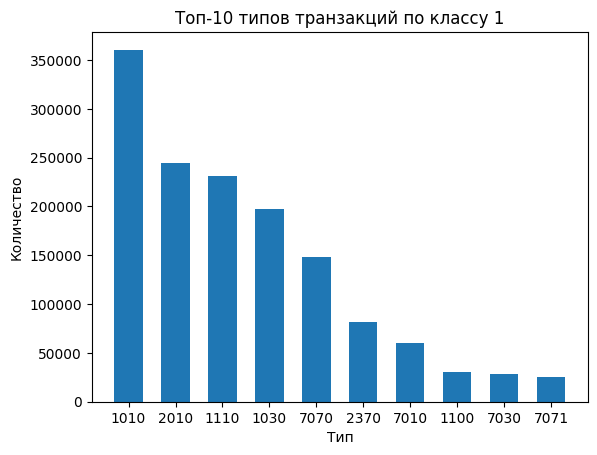

In [50]:
x_tr_1 = transactions_train[transactions_train.gender == 1]['trans_type'].value_counts().head(10).index.astype(str)
y_tr_1 = transactions_train[transactions_train.gender == 1]['trans_type'].value_counts().head(10).values

plt.bar(x_tr_1, y_tr_1, width=0.6)
plt.title('Топ-10 типов транзакций по классу 1')
plt.xlabel('Тип')
plt.ylabel('Количество')


In [53]:
print('1010:',tr_types.loc[1010, 'trans_description'])
print('2010:',tr_types.loc[2010, 'trans_description'])
print('1110:',tr_types.loc[1110, 'trans_description'])
print('1030:',tr_types.loc[1030, 'trans_description'])
print('7070:',tr_types.loc[7070, 'trans_description'])
print('2370:',tr_types.loc[2370, 'trans_description'])
print('7010:',tr_types.loc[7010, 'trans_description'])
print('1100:',tr_types.loc[1100, 'trans_description'])
print('7030:',tr_types.loc[7030, 'trans_description'])
print('7071:',tr_types.loc[7071, 'trans_description'])

1010: Покупка. POS ТУ СБ РФ
2010: Выдача наличных в АТМ Сбербанк России
1110: Покупка. POS ТУ Россия
1030: Оплата услуги. Банкоматы СБ РФ
7070: Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)
2370: Списание с карты на карту по операции <перевода с карты на карту> через Мобильный банк (без комиссии)
7010: Взнос наличных через АТМ (в своем тер.банке)
1100: Покупка. ТУ  Россия
7030: Перевод на карту (с карты) через АТМ (в пределах одного тер.банка)
7071: Перевод на карту (с карты) через Мобильный банк (с взиманием комиссии с отправителя)


Text(0, 0.5, 'Количество')

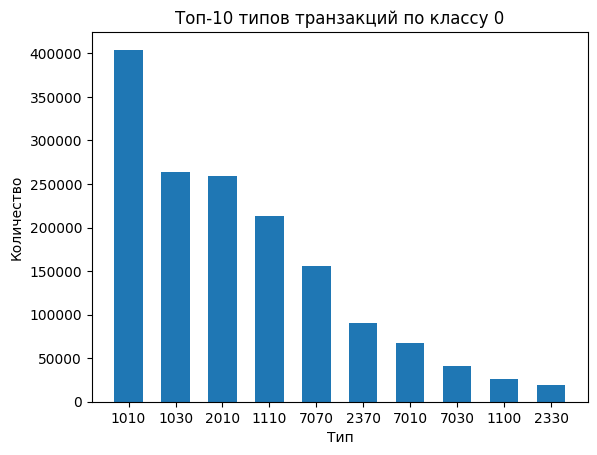

In [54]:
x_tr_0 = transactions_train[transactions_train.gender == 0]['trans_type'].value_counts().head(10).index.astype(str)
y_tr_0 = transactions_train[transactions_train.gender == 0]['trans_type'].value_counts().head(10).values

plt.bar(x_tr_0, y_tr_0, width=0.6)
plt.title('Топ-10 типов транзакций по классу 0')
plt.xlabel('Тип')
plt.ylabel('Количество')


In [56]:
print('1010:',tr_types.loc[1010, 'trans_description'])
print('1030:',tr_types.loc[1030, 'trans_description'])
print('2010:',tr_types.loc[2010, 'trans_description'])
print('1110:',tr_types.loc[1110, 'trans_description'])
print('7070:',tr_types.loc[7070, 'trans_description'])
print('2370:',tr_types.loc[2370, 'trans_description'])
print('7010:',tr_types.loc[7010, 'trans_description'])
print('7030:',tr_types.loc[7030, 'trans_description'])
print('1100:',tr_types.loc[1100, 'trans_description'])
print('2330:',tr_types.loc[2330, 'trans_description'])

1010: Покупка. POS ТУ СБ РФ
1030: Оплата услуги. Банкоматы СБ РФ
2010: Выдача наличных в АТМ Сбербанк России
1110: Покупка. POS ТУ Россия
7070: Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)
2370: Списание с карты на карту по операции <перевода с карты на карту> через Мобильный банк (без комиссии)
7010: Взнос наличных через АТМ (в своем тер.банке)
7030: Перевод на карту (с карты) через АТМ (в пределах одного тер.банка)
1100: Покупка. ТУ  Россия
2330: Списание с карты по операции “перевода с карты на карту” через АТМ (в пределах одного тер.банка)


## Генерация фичей

Для тренировки модели, создадим временные фичи:
- Номер дня в месяце
- Месяц
- День
- Час
- Тип дня (будни, пятница, выходные)
- Время суток (утро, день, вечер, ночь)

In [65]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

transactions_train.head()

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender,day_month,month,day,hour,type_day,part_day,night
client_id,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0,13,10,5,14,weekend,daytime,-2
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0,0,5,3,14,weekday,daytime,-2
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0,2,4,3,12,weekday,daytime,-2
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0,9,5,5,13,weekend,daytime,-2
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0,17,8,5,12,weekend,daytime,-2


In [66]:
transactions_train.shape

(3238732, 15)

In [67]:
transactions_train.shape

(3238732, 15)

Посчитаем для каждого пользователя количество транзакций в определенные часы, дни, месяцы. Разделим транзакции на положительные (пришли средства) и отрицательные (ушли средства), а затем на основе этого посчитаем для каждого пользователя минимум, максимум, среднее, медиану и другие агрегирующие функции. Также, посчитаем количество транзакций по MCC кодам и типам транзакций.

In [68]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    
    features.append(pd.Series(x[x['amount']>=0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))

    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    
    return pd.concat(features)

In [51]:
data_train

,"(dm_pd_0, dm_pd_daytime)","(dm_pd_0, dm_pd_evening)","(dm_pd_0, dm_pd_morning)","(dm_pd_0, dm_pd_night)","(dm_pd_1, dm_pd_daytime)","(dm_pd_1, dm_pd_evening)","(dm_pd_1, dm_pd_morning)","(dm_pd_1, dm_pd_night)","(dm_pd_10, dm_pd_daytime)","(dm_pd_10, dm_pd_evening)",...,tr_7070,tr_7071,tr_7074,tr_7075,tr_8100,tr_8145,tr_8146,type_day_friday,type_day_weekday,type_day_weekend
client_id,,,,,,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,0.025794,NaN,0.011905,NaN,0.013889,0.001984,0.023810,NaN,0.011905,NaN,...,0.005952,NaN,NaN,NaN,NaN,NaN,NaN,0.125000,0.501984,0.373016
0002f4661e0d4d2ae097d78552dad022,0.011236,0.003745,0.011236,NaN,0.029963,0.022472,0.003745,NaN,0.018727,NaN,...,0.007491,NaN,NaN,NaN,NaN,NaN,NaN,0.153558,0.591760,0.254682
00081e0eca8ad94e493691f8f00099c6,0.005236,0.026178,NaN,NaN,0.010471,NaN,0.026178,0.005236,0.005236,0.005236,...,0.083770,0.015707,NaN,NaN,NaN,NaN,NaN,0.162304,0.570681,0.267016
0019bebcb5435df3103a5b0b52f5fc6b,0.008282,0.015528,0.003106,0.007246,0.004141,0.012422,NaN,0.008282,0.003106,0.020704,...,0.179089,0.017598,0.007246,NaN,NaN,NaN,NaN,0.136646,0.576605,0.286749
001c8191ecac499718b33dc293a99e5b,0.014563,NaN,0.009709,0.004854,0.019417,0.004854,0.014563,0.004854,NaN,NaN,...,0.033981,NaN,NaN,NaN,NaN,NaN,NaN,0.169903,0.558252,0.271845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe87ae84cf5d83af6a8a5de6dfe327f,0.017782,0.013598,0.003138,0.006276,0.020921,0.004184,0.010460,0.007322,0.011506,0.007322,...,0.190377,NaN,0.001046,NaN,NaN,NaN,NaN,0.141213,0.517782,0.341004
fff69a007a119605d6ff25c086840e7d,0.014327,0.017192,0.008596,0.008596,0.014327,0.005731,0.020057,0.005731,NaN,0.005731,...,0.008596,NaN,NaN,NaN,NaN,NaN,NaN,0.157593,0.532951,0.309456
fff78af489ca1024ba0ac7b3c2e47b60,0.017143,NaN,0.017143,NaN,0.005714,0.005714,NaN,NaN,0.011429,0.011429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160000,0.480000,0.360000


In [61]:
data_test

,"(dm_pd_0, dm_pd_daytime)","(dm_pd_0, dm_pd_evening)","(dm_pd_0, dm_pd_morning)","(dm_pd_0, dm_pd_night)","(dm_pd_1, dm_pd_daytime)","(dm_pd_1, dm_pd_evening)","(dm_pd_1, dm_pd_morning)","(dm_pd_1, dm_pd_night)","(dm_pd_10, dm_pd_daytime)","(dm_pd_10, dm_pd_evening)",...,tr_7035,tr_7040,tr_7041,tr_7070,tr_7071,tr_7074,tr_7075,type_day_friday,type_day_weekday,type_day_weekend
client_id,,,,,,,,,,,,,,,,,,,,,
002218c52073faaf23bb26df2cffb138,0.016129,NaN,NaN,NaN,0.008065,NaN,0.024194,NaN,0.008065,0.008065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177419,0.604839,0.217742
0069d4050c7aeb341317e2e125e8fd2e,NaN,0.011236,NaN,NaN,0.018727,0.003745,0.003745,0.003745,0.029963,0.018727,...,NaN,NaN,NaN,0.003745,NaN,NaN,NaN,0.153558,0.629213,0.217228
0083fb89aea18c408a5534cdd38d7692,0.008451,0.005634,0.008451,0.005634,0.019718,0.002817,0.008451,0.002817,0.005634,0.005634,...,NaN,NaN,NaN,0.033803,NaN,NaN,NaN,0.140845,0.523944,0.335211
014021fa559786c81e9e1d48d378aabb,0.025316,0.016275,0.012658,0.009042,0.009042,0.009042,0.007233,0.003617,0.014467,0.001808,...,NaN,NaN,NaN,0.112116,NaN,NaN,NaN,0.144665,0.564195,0.291139
01759f92152bbb3de79f9493a4a5cd6d,0.006667,0.003333,0.013333,0.003333,0.006667,NaN,0.023333,0.006667,0.006667,NaN,...,NaN,NaN,NaN,0.023333,NaN,NaN,NaN,0.133333,0.676667,0.190000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe084e295034c4bd6ae4498af6882bb5,0.013889,0.013889,0.020833,NaN,0.027778,0.027778,NaN,NaN,NaN,0.006944,...,NaN,NaN,NaN,0.013889,NaN,NaN,NaN,0.083333,0.625000,0.291667
fe9c3e9c58a97ba6c2922237bfc2a7c6,0.014451,0.011561,0.011561,0.008671,0.002890,0.005780,0.002890,0.005780,0.014451,0.002890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150289,0.528902,0.320809
fee8ac01c79388b623134d61d49c8900,0.013514,0.013514,0.002703,NaN,0.018919,0.010811,0.008108,0.002703,0.008108,0.005405,...,NaN,NaN,NaN,NaN,0.002703,NaN,NaN,0.137838,0.581081,0.281081


In [69]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']
target.value_counts()

Progress::   0%|          | 0/7560 [00:00<?, ?it/s]

Progress::   0%|          | 0/840 [00:00<?, ?it/s]

gender
0    4199
1    3361
Name: count, dtype: int64

In [88]:
data_test

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_sum,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std,positive_transactions_sum
client_id,,,,,,,,,,,,,,,,,,,,,
002218c52073faaf23bb26df2cffb138,0.177419,0.088710,0.120968,0.217742,0.177419,0.088710,0.129032,NaN,NaN,0.129032,...,-105534.44,0.024194,0.975806,8.0,10847.44,3570.697500,724.090,722.73,4574.936860,28565.58
0069d4050c7aeb341317e2e125e8fd2e,0.191011,0.142322,0.063670,0.232210,0.153558,0.086142,0.131086,0.022472,0.007491,0.026217,...,-220628.11,0.104869,0.895131,61.0,3978.15,821.506066,361.220,7.37,1139.701734,50111.87
0083fb89aea18c408a5534cdd38d7692,0.183099,0.104225,0.070423,0.166197,0.140845,0.171831,0.163380,0.028169,0.008451,0.112676,...,-504365.54,0.107042,0.892958,36.0,72312.69,11287.826667,2169.745,107.78,22305.768042,406361.76
014021fa559786c81e9e1d48d378aabb,0.166365,0.142857,0.108499,0.146474,0.144665,0.122966,0.168174,0.070524,NaN,0.130199,...,-489369.18,0.146474,0.853526,62.0,7592.34,2611.545323,2169.560,2.71,1934.351733,161915.81
01759f92152bbb3de79f9493a4a5cd6d,0.113333,0.166667,0.210000,0.186667,0.133333,0.093333,0.096667,0.013333,0.030000,0.090000,...,-169648.23,0.263333,0.736667,39.0,21692.85,3041.005897,1229.160,15.43,4200.811342,118599.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe084e295034c4bd6ae4498af6882bb5,0.138889,0.263889,0.125000,0.097222,0.083333,0.173611,0.118056,NaN,NaN,0.097222,...,-260663.76,0.041667,0.958333,5.0,36156.98,16906.922000,14462.920,72.08,17209.516484,84534.61
fe9c3e9c58a97ba6c2922237bfc2a7c6,0.158960,0.083815,0.095376,0.190751,0.150289,0.132948,0.187861,0.118497,NaN,0.054913,...,-46648.83,0.234104,0.765896,3.0,1446.05,1084.553333,1084.510,723.10,361.475002,3253.66
fee8ac01c79388b623134d61d49c8900,0.151351,0.151351,0.151351,0.127027,0.137838,0.156757,0.124324,0.010811,NaN,0.078378,...,-236280.59,0.040541,0.959459,4.0,36156.18,23681.735000,28924.330,722.10,16756.148841,94726.94


In [73]:
print(data_train.shape)
print(data_test.shape)

(7560, 231)
(840, 227)


In [74]:
common_columns = np.intersect1d(data_train.columns, data_test.columns, assume_unique=True)
data_train = data_train[common_columns]
print(data_train.shape)

(7560, 227)


In [75]:
X = data_train.copy()
y = target
test_df = data_test.copy()

# Заполним пустые значения нулями
X.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

X.shape, test_df.shape, y.shape

((7560, 227), (840, 227), (7560,))

In [12]:
test_df

,"(dm_pd_0, dm_pd_daytime)","(dm_pd_0, dm_pd_evening)","(dm_pd_0, dm_pd_morning)","(dm_pd_0, dm_pd_night)","(dm_pd_1, dm_pd_daytime)","(dm_pd_1, dm_pd_evening)","(dm_pd_1, dm_pd_morning)","(dm_pd_1, dm_pd_night)","(dm_pd_10, dm_pd_daytime)","(dm_pd_10, dm_pd_evening)",...,tr_7035,tr_7040,tr_7041,tr_7070,tr_7071,tr_7074,tr_7075,type_day_friday,type_day_weekday,type_day_weekend
client_id,,,,,,,,,,,,,,,,,,,,,
002218c52073faaf23bb26df2cffb138,0.016129,0.000000,0.000000,0.000000,0.008065,0.000000,0.024194,0.000000,0.008065,0.008065,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.177419,0.604839,0.217742
0069d4050c7aeb341317e2e125e8fd2e,0.000000,0.011236,0.000000,0.000000,0.018727,0.003745,0.003745,0.003745,0.029963,0.018727,...,0.0,0.0,0.0,0.003745,0.000000,0.0,0.0,0.153558,0.629213,0.217228
0083fb89aea18c408a5534cdd38d7692,0.008451,0.005634,0.008451,0.005634,0.019718,0.002817,0.008451,0.002817,0.005634,0.005634,...,0.0,0.0,0.0,0.033803,0.000000,0.0,0.0,0.140845,0.523944,0.335211
014021fa559786c81e9e1d48d378aabb,0.025316,0.016275,0.012658,0.009042,0.009042,0.009042,0.007233,0.003617,0.014467,0.001808,...,0.0,0.0,0.0,0.112116,0.000000,0.0,0.0,0.144665,0.564195,0.291139
01759f92152bbb3de79f9493a4a5cd6d,0.006667,0.003333,0.013333,0.003333,0.006667,0.000000,0.023333,0.006667,0.006667,0.000000,...,0.0,0.0,0.0,0.023333,0.000000,0.0,0.0,0.133333,0.676667,0.190000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe084e295034c4bd6ae4498af6882bb5,0.013889,0.013889,0.020833,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,0.006944,...,0.0,0.0,0.0,0.013889,0.000000,0.0,0.0,0.083333,0.625000,0.291667
fe9c3e9c58a97ba6c2922237bfc2a7c6,0.014451,0.011561,0.011561,0.008671,0.002890,0.005780,0.002890,0.005780,0.014451,0.002890,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.150289,0.528902,0.320809
fee8ac01c79388b623134d61d49c8900,0.013514,0.013514,0.002703,0.000000,0.018919,0.010811,0.008108,0.002703,0.008108,0.005405,...,0.0,0.0,0.0,0.000000,0.002703,0.0,0.0,0.137838,0.581081,0.281081


## Модель

In [26]:
# Подобранные оптимальные гиперпараметры

params = {
    'num_trees': 270,
    'learning_rate': 0.08,
    'depth': 8,
    'l2_leaf_reg': 2.5,
    'verbose' : False
    'eval_metric'
}

Оценим модель по метрикам ROC AUC и F1.

In [76]:
train_indices, test_indices = train_test_split(y.index, test_size=0.2)

train_x = X.loc[train_indices, :]
train_y = y.loc[train_indices]

test_x = X.loc[test_indices, :]
test_y = y.loc[test_indices]

model = CatBoostClassifier(**params)
model.fit(train_x, train_y)

In [36]:
test_y

client_id
4c0f74f2565d89d3aa84bdac583f11ab    1
7c3d4dea109131074b2b7693e190b7f5    0
1cf32ae23bff87487b82bdc22bd4aecd    1
c16064e772dbf4c6ae94fa56a1d5fc64    1
dc82be1a609a4e3fefdface98745d774    0
                                   ..
2da0e940c424cc706bc60462d70b9d68    1
5ff37a12fbdbacb4ec460af3d5871539    0
2c081a938a96f12c2577fcf53f157318    0
217a34815abecdadea76fe5bffa85269    1
a9f650464cd782b8940718b4ef6a1dc7    0
Name: gender, Length: 1512, dtype: int64

In [77]:
y_pred = model.predict(test_x)
metric_auc = roc_auc_score(test_y, y_pred)
metric_f1 = f1_score(test_y, y_pred)

print('ROC AUC:', metric_auc)
print('F1 score:', metric_f1)

ROC AUC: 0.7873124841088228
F1 score: 0.7596302003081664


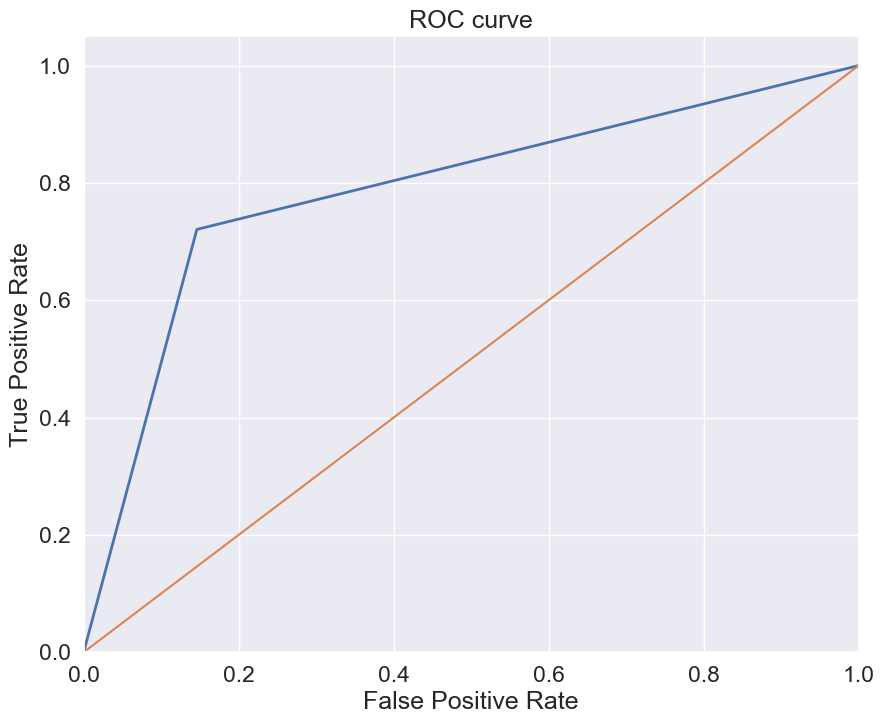

In [78]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Обучим модель на всех данных

In [79]:
pred_model = CatBoostClassifier(**params)

pred_model.fit(X, y)

In [80]:
y_pred = model.predict(X)
metric_auc = roc_auc_score(y, y_pred)
metric_f1 = f1_score(y, y_pred)

print('ROC AUC:', metric_auc)
print('F1 score:', metric_f1)

ROC AUC: 0.9484592363024902
F1 score: 0.9436130007558579


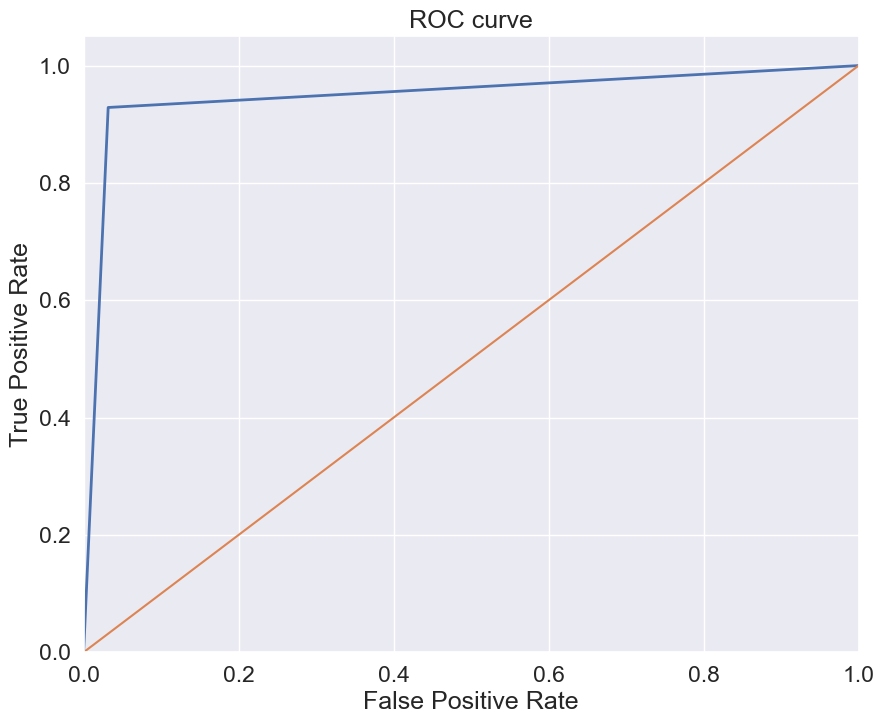

In [86]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [85]:
pred_model.save_model('model_94.84', format='cbm')

In [81]:
predict = pred_model.predict_proba(test_df)

In [87]:
submission = pd.DataFrame(index=data_test.index)
submission['probability'] = predict[:,1]
submission.to_csv('final_submission.csv')
submission.head()

,probability
client_id,
002218c52073faaf23bb26df2cffb138,0.928331
0069d4050c7aeb341317e2e125e8fd2e,0.638106
0083fb89aea18c408a5534cdd38d7692,0.310629
014021fa559786c81e9e1d48d378aabb,0.883720
01759f92152bbb3de79f9493a4a5cd6d,0.585617
